<a href="https://colab.research.google.com/github/hnabid/DEEP-LEARNING/blob/main/lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [3]:
x_train = np.load('/content/drive/MyDrive/dataset/x_train.npy')
y_train = np.load('/content/drive/MyDrive/dataset/x_val.npy')
x_val = np.load('/content/drive/MyDrive/dataset/y_train.npy')
y_val = np.load('/content/drive/MyDrive/dataset/y_val.npy')


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob

In [5]:
img_list = sorted(glob.glob('/content/drive/MyDrive/2d_images/*.tif'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


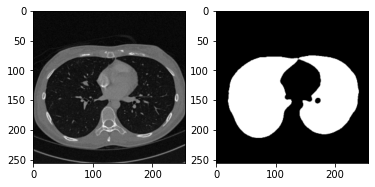

In [6]:
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

np.save('/content/drive/MyDrive/dataset/x_train.npy', x_train)
np.save('/content/drive/MyDrive/dataset/x_val.npy', y_train)
np.save('/content/drive/MyDrive/dataset/y_train.npy', x_val)
np.save('/content/drive/MyDrive/dataset/y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [8]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [9]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100
8/8 [==============================] - 19s 621ms/step - loss: 0.6058 - acc: 0.6765 - mse: 0.2038 - val_loss: 0.4883 - val_acc: 0.7433 - val_mse: 0.1593 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 185ms/step - loss: 0.4884 - acc: 0.7521 - mse: 0.1589 - val_loss: 0.4543 - val_acc: 0.7433 - val_mse: 0.1481 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 184ms/step - loss: 0.4528 - acc: 0.7521 - mse: 0.1474 - val_loss: 0.4894 - val_acc: 0.7433 - val_mse: 0.1663 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 186ms/step - loss: 0.4322 - acc: 0.7521 - mse: 0.1430 - val_loss: 0.4011 - val_acc: 0.7445 - val_mse: 0.1305 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 186ms/step - loss: 0.4089 - acc: 0.7565 - mse: 0.1350 - val_loss: 0.5320 - val_acc: 0.6558 - val_mse: 0.1832 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 1s 185ms/step - loss: 0.4451 - acc: 0.7339 - mse: 0.1491 - val_loss:

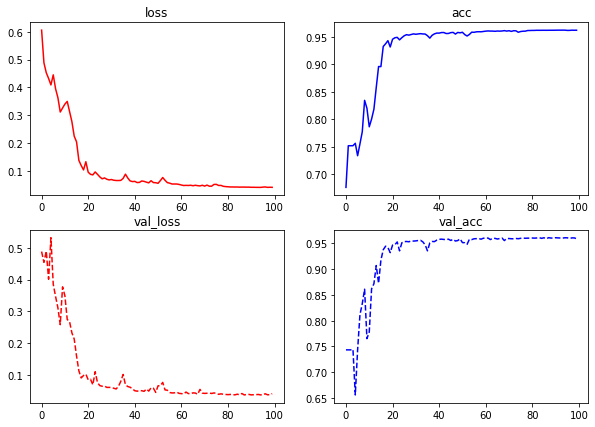

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

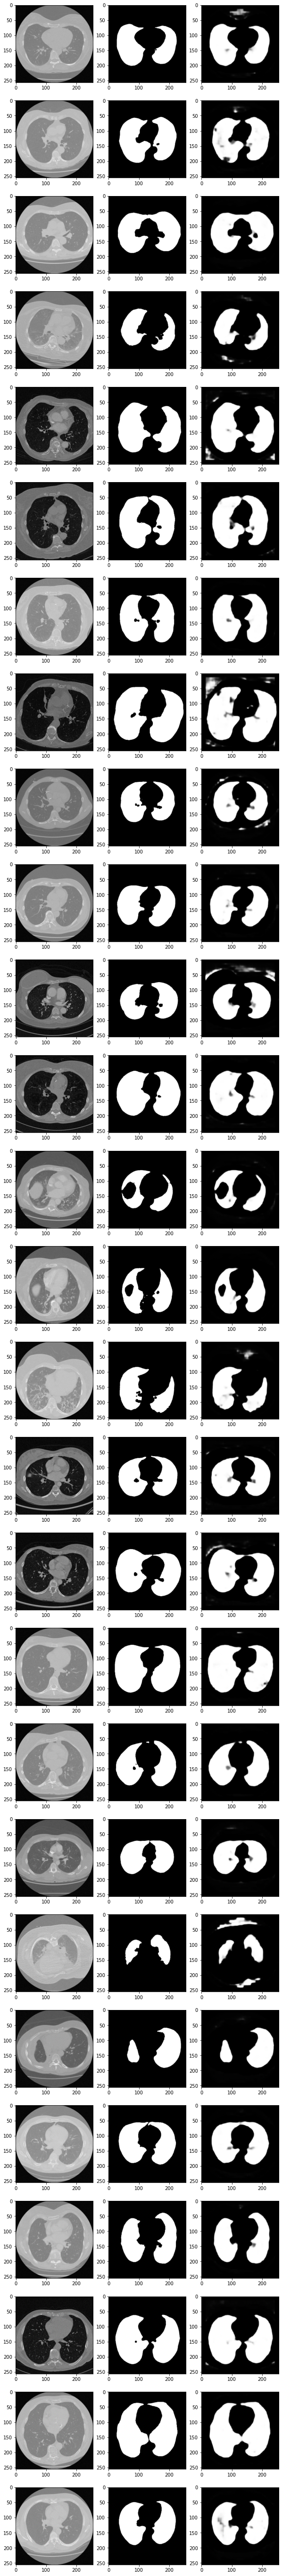

In [11]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')